### Installation and setup

In [1]:
# Install necessary libraries
!pip install -q -U transformers
!pip install -q pycocotools
!pip install -q nltk

# Download NLTK data for synonyms
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### Configuration and Imports

In [2]:
# --- Cell: Setup imports & configuration ---
import os, json, csv, random, math, time, re
from pathlib import Path
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import torch
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# Transformers
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

# pycocotools (optional)
try:
    from pycocotools.coco import COCO
    from pycocotools.cocoeval import COCOeval
    _HAS_COCO = True
except Exception:
    _HAS_COCO = False

# NLTK (optional for synonyms)
try:
    import nltk
    from nltk.corpus import wordnet as wn
    _HAS_NLTK = True
except Exception:
    _HAS_NLTK = False

# Basic config - adapt paths if needed
ROOT = Path.cwd()
# Change these paths to point to your dataset location on Kaggle
TEST_IMG_DIR = Path("/kaggle/input/zero-shot-datase/val2017/val2017")
COCO_JSON = Path("/kaggle/input/zero-shot-datase/instances_val2017.json")
OUTPUT_DIR = Path("/kaggle/working/grounding_dino_final_outputs")
OUT_VIS_DIR = OUTPUT_DIR / "visualizations"
OUT_VIS_DIR.mkdir(parents=True, exist_ok=True)

# CSV outputs (per-strategy)
OUT_CSV_BASELINE = OUTPUT_DIR / "predictions_baseline.csv"
OUT_CSV_EXPANDED = OUTPUT_DIR / "predictions_detailed.csv"
OUT_CSV_SYNONYMS = OUTPUT_DIR / "predictions_synonyms.csv"

# Model config
MODEL_ID = "IDEA-Research/grounding-dino-base"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Inference config
CHUNK_SIZE = 12
SCORE_THRESHOLD = 0.35
TEXT_THRESHOLD = 0.25
NMS_IOU = 0.45

print("Setup done. Device:", DEVICE, "Has COCO:", _HAS_COCO, "Has NLTK:", _HAS_NLTK)

2025-09-17 13:35:08.625566: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758116108.648348     188 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758116108.655223     188 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Setup done. Device: cuda Has COCO: True Has NLTK: True


### Helper Function

In [3]:
# --- Cell: Helpers: robust draw_and_save, iou, nms ---
from PIL import ImageDraw, ImageFont

def draw_and_save(image_pil, boxes, labels, scores, out_path, max_label_len=60):
    """
    Robust drawing function that uses draw.textbbox (fallback safe) to size label background.
    Saves image to out_path.
    """
    im = image_pil.copy()
    draw = ImageDraw.Draw(im)
    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf", 14)
    except Exception:
        font = ImageFont.load_default()

    for box, lab, sc in zip(boxes, labels, scores):
        try:
            x0, y0, x1, y1 = [int(round(float(v))) for v in box]
        except Exception:
            continue
        txt = f"{lab[:max_label_len]} {sc:.2f}"

        # draw bbox
        draw.rectangle([x0, y0, x1, y1], outline="red", width=2)

        # robust text size
        try:
            tb = draw.textbbox((0,0), txt, font=font)
            tw, th = tb[2] - tb[0], tb[3] - tb[1]
        except Exception:
            tw, th = (len(txt) * 6, 12)

        tx0 = x0
        ty0 = max(0, y0 - th - 6)
        draw.rectangle([tx0, ty0, tx0 + tw + 6, ty0 + th + 4], fill="red")
        draw.text((tx0 + 3, ty0 + 2), txt, fill="white", font=font)

    Path(out_path).parent.mkdir(parents=True, exist_ok=True)
    im.save(out_path, quality=90)


def iou_xyxy(boxA, boxB):
    xA, yA = max(boxA[0], boxB[0]), max(boxA[1], boxB[1])
    xB, yB = min(boxA[2], boxB[2]), min(boxA[3], boxB[3])
    interW, interH = max(0, xB - xA), max(0, yB - yA)
    inter = interW * interH
    areaA = max(0, (boxA[2]-boxA[0])*(boxA[3]-boxA[1]))
    areaB = max(0, (boxB[2]-boxB[0])*(boxB[3]-boxB[1]))
    union = areaA + areaB - inter
    return inter / union if union > 0 else 0.0

def simple_nms(boxes, scores, iou_thresh=NMS_IOU):
    if not boxes:
        return []
    idxs = np.argsort(scores)[::-1].tolist()
    keep = []
    while idxs:
        i = idxs.pop(0)
        keep.append(i)
        idxs = [j for j in idxs if iou_xyxy(boxes[i], boxes[j]) <= iou_thresh]
    return keep

# Milestone 1: Prepare Dataset and Prompts


In [4]:
# --- Cell: Milestone 1 - prepare test images list and baseline prompts ---
TEST_LIST_FILE = ROOT / "test_images_list.txt"
PROMPTS_BASELINE_FILE = ROOT / "prompts_baseline.txt"

# Build selected_images: if test_images_list.txt available read it; else sample images from TEST_IMG_DIR.
if TEST_LIST_FILE.exists():
    selected_images = [Path(p.strip()) for p in TEST_LIST_FILE.read_text().splitlines() if p.strip()]
    selected_images = [p if p.is_absolute() else TEST_IMG_DIR / p for p in selected_images]
else:
    imgs = sorted([p for p in TEST_IMG_DIR.glob("*") if p.suffix.lower() in [".jpg",".jpeg",".png"]])
    if len(imgs) == 0:
        raise FileNotFoundError(f"No images found in {TEST_IMG_DIR}. Please set TEST_IMG_DIR correctly or create {TEST_LIST_FILE}.")
    # choose between 50..100 or all if fewer
    k = min(max(50, len(imgs)), min(100, len(imgs)))
    selected_images = imgs[:k]
    # write a list for reproducibility
    TEST_LIST_FILE.parent.mkdir(parents=True, exist_ok=True)
    TEST_LIST_FILE.write_text("\n".join([str(p.name) for p in selected_images]))
print("Selected images:", len(selected_images), " -> example:", selected_images[:3])

# Build baseline prompts: prefer user file; else try COCO JSON categories; else few defaults
baseline_prompts = []
if PROMPTS_BASELINE_FILE.exists():
    baseline_prompts = [l.strip() for l in PROMPTS_BASELINE_FILE.read_text().splitlines() if l.strip()]
else:
    if COCO_JSON.exists():
        ann = json.load(open(COCO_JSON))
        cats = [c["name"] for c in ann.get("categories", [])]
        baseline_prompts = [c.lower().strip() + "." for c in cats]
    else:
        baseline_prompts = ["a person.", "a car.", "a dog.", "a cat.", "a bicycle.", "a chair.", "a table."]

    PROMPTS_BASELINE_FILE.write_text("\n".join(baseline_prompts))

print("Baseline prompts:", len(baseline_prompts), " -> example:", baseline_prompts[:8])

Selected images: 100  -> example: [PosixPath('/kaggle/input/zero-shot-datase/val2017/val2017/000000000139.jpg'), PosixPath('/kaggle/input/zero-shot-datase/val2017/val2017/000000000285.jpg'), PosixPath('/kaggle/input/zero-shot-datase/val2017/val2017/000000000632.jpg')]
Baseline prompts: 80  -> example: ['person.', 'bicycle.', 'car.', 'motorcycle.', 'airplane.', 'bus.', 'train.', 'truck.']


# Milestone 2 & 4: Run Experiments

In [5]:
# --- Cell: Milestone 2 & 4 - load model and run all experiments ---
processor = AutoProcessor.from_pretrained(MODEL_ID)
model = AutoModelForZeroShotObjectDetection.from_pretrained(MODEL_ID).to(DEVICE)
model.eval()

# Minimal is baseline
prompts_minimal = baseline_prompts

# Detailed: short descriptive templates
prompts_detailed = []
for p in baseline_prompts:
    lab = p.rstrip(".")
    sent = f"a photo of a {lab} in a natural scene."
    prompts_detailed.append(sent if sent.endswith(".") else sent + ".")

# Synonyms: try NLTK WordNet, else fallback to a tiny heuristic
def get_synonyms(word, max_syn=3):
    word = re.sub(r'[^a-z0-9\s]', '', word.lower()).strip()
    if _HAS_NLTK:
        syns = set()
        for syn in wn.synsets(word):
            for lemma in syn.lemmas():
                cand = lemma.name().replace("_"," ").lower()
                cand = re.sub(r'[^a-z0-9\s]', '', cand).strip()
                if cand and cand != word and len(cand) >= 3:
                    syns.add(cand)
                if len(syns) >= max_syn*3:
                    break
            if len(syns) >= max_syn*3:
                break
        return [s for s in sorted(syns)][:max_syn]
    else:
        # fallback: small manual map for common labels
        fallback = {"person":["individual","human"], "car":["auto","automobile"], "bicycle":["bike","cycle"]}
        return fallback.get(word, [])[:max_syn]

# Build synonym-expanded prompts (flat)
prompts_synonym_expanded = []
syn_map = {}
MAX_SYNS = 3
for p in baseline_prompts:
    lbl = p.rstrip(".")
    syns = get_synonyms(lbl, MAX_SYNS)
    syn_map[lbl] = syns
    items = [lbl] + syns
    items = [it + "." if not it.endswith(".") else it for it in items]
    prompts_synonym_expanded.extend(items)

print("Detailed example:", prompts_detailed[:4])
print("Synonym map examples:", list(syn_map.items())[:6])

# Runner (re-usable): saves per-strategy folder under OUT_VIS_DIR/<prefix>/
def run_prompts_on_images(prompt_list, out_csv_path, out_vis_prefix, chunk_size=CHUNK_SIZE, device=DEVICE):
    vis_folder = OUT_VIS_DIR / out_vis_prefix
    vis_folder.mkdir(parents=True, exist_ok=True)
    rows = []
    for img_p in selected_images:
        img = Image.open(img_p).convert("RGB")
        all_boxes, all_scores, all_labels = [], [], []
        for i in range(0, len(prompt_list), chunk_size):
            chunk = prompt_list[i:i+chunk_size]
            inputs = processor(images=img, text=" ".join(chunk), return_tensors="pt").to(device)
            with torch.no_grad():
                outputs = model(**inputs)
            res = processor.post_process_grounded_object_detection(
                outputs, inputs.input_ids, threshold=SCORE_THRESHOLD, text_threshold=TEXT_THRESHOLD, target_sizes=[img.size[::-1]]
            )[0]
            boxes = [b.tolist() for b in res.get("boxes", [])]
            scores = [float(s) for s in res.get("scores", [])]
            raw_labels = res.get("labels", [])
            text_labels = res.get("text_labels", None)

            if text_labels is not None and len(text_labels) == len(raw_labels):
                labels_for_loop = text_labels
            else:
                labels_for_loop = []
                for rl in raw_labels:
                    if isinstance(rl, (int, np.integer)):
                        idx = int(rl)
                        if 0 <= idx < len(chunk):
                            labels_for_loop.append(chunk[idx].strip())
                        else:
                            labels_for_loop.append(str(rl))
                    else:
                        labels_for_loop.append(str(rl).strip())

            for lab, box, sc in zip(labels_for_loop, boxes, scores):
                all_boxes.append(box); all_scores.append(sc); all_labels.append(lab)

        if all_boxes:
            keep = simple_nms(all_boxes, all_scores, iou_thresh=NMS_IOU)
            boxes_final = [all_boxes[i] for i in keep]
            scores_final = [all_scores[i] for i in keep]
            labels_final = [all_labels[i] for i in keep]
        else:
            boxes_final, scores_final, labels_final = [], [], []

        vis_name = vis_folder / f"{Path(img_p).stem}_{out_vis_prefix}.jpg"
        draw_and_save(img, boxes_final, labels_final, scores_final, str(vis_name))

        for box, score, label in zip(boxes_final, scores_final, labels_final):
            x0,y0,x1,y1 = box
            rows.append({"file_name": Path(img_p).name, "x0": x0, "y0": y0, "x1": x1, "y1": y1, "label": label.rstrip("."), "score": float(score)})

    out_csv_path = Path(out_csv_path)
    out_csv_path.parent.mkdir(parents=True, exist_ok=True)
    with open(out_csv_path, "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=["file_name","x0","y0","x1","y1","label","score"])
        writer.writeheader()
        writer.writerows(rows)

    print(f"Saved {len(rows)} detections -> {out_csv_path}")
    print("Visuals in:", vis_folder)
    return out_csv_path

# Run the experiments (these will create subfolders baseline/detailed/synonyms)
out_min = run_prompts_on_images(prompts_minimal, OUT_CSV_BASELINE, "baseline")
out_det = run_prompts_on_images(prompts_detailed, OUT_CSV_EXPANDED, "detailed")
out_syn = run_prompts_on_images(prompts_synonym_expanded, OUT_CSV_SYNONYMS, "synonyms")

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Detailed example: ['a photo of a person in a natural scene.', 'a photo of a bicycle in a natural scene.', 'a photo of a car in a natural scene.', 'a photo of a motorcycle in a natural scene.']
Synonym map examples: [('person', ['individual', 'mortal', 'somebody']), ('bicycle', ['bike', 'cycle', 'pedal']), ('car', ['auto', 'automobile', 'elevator car']), ('motorcycle', ['bike', 'cycle', 'motorbike']), ('airplane', ['aeroplane', 'plane']), ('bus', ['autobus', 'charabanc', 'coach'])]


/usr/local/lib/python3.11/dist-packages/transformers/models/grounding_dino/processing_grounding_dino.py:99: FutureWarning: The key `labels` is will return integer ids in `GroundingDinoProcessor.post_process_grounded_object_detection` output since v4.51.0. Use `text_labels` instead to retrieve string object names.
  warnings.warn(self.message, FutureWarning)


Saved 641 detections -> /kaggle/working/grounding_dino_final_outputs/predictions_baseline.csv
Visuals in: /kaggle/working/grounding_dino_final_outputs/visualizations/baseline
Saved 170 detections -> /kaggle/working/grounding_dino_final_outputs/predictions_detailed.csv
Visuals in: /kaggle/working/grounding_dino_final_outputs/visualizations/detailed
Saved 444 detections -> /kaggle/working/grounding_dino_final_outputs/predictions_synonyms.csv
Visuals in: /kaggle/working/grounding_dino_final_outputs/visualizations/synonyms


# Milestone 3: Evaluation and Visualization

In [7]:
# --- Cell: Milestone 3 - Evaluation and Visualization ---

def csv_to_coco_dets(pred_csv_path, coco_json_path, out_json_path):
    rows = []
    with open(pred_csv_path, newline="") as f:
        reader = csv.DictReader(f)
        for r in reader:
            rows.append(r)
    if not Path(coco_json_path).exists():
        print("COCO GT JSON not found:", coco_json_path)
        return None

    coco = COCO(str(coco_json_path))
    imgname_to_id = {img['file_name']: img['id'] for img in coco.loadImgs(coco.getImgIds())}
    catname_to_id = {c['name'].lower(): c['id'] for c in coco.loadCats(coco.getCatIds())}

    mapped = []
    skipped = 0
    for r in rows:
        fname = r.get("file_name")
        if fname not in imgname_to_id:
            skipped += 1
            continue
        image_id = imgname_to_id[fname]
        x0 = float(r["x0"]); y0 = float(r["y0"]); x1 = float(r["x1"]); y1 = float(r["y1"])
        w = x1 - x0; h = y1 - y0
        score = float(r.get("score", 0.0))
        cat = r.get("label","").lower().strip().rstrip(".")
        cat_id = catname_to_id.get(cat)
        if cat_id is None:
            cat_id = catname_to_id.get(cat.split()[0]) if cat else None
        if cat_id is None:
            skipped += 1
            continue
        mapped.append({"image_id": int(image_id), "category_id": int(cat_id), "bbox":[x0,y0,w,h], "score": float(score)})

    out_json_path = Path(out_json_path)
    out_json_path.parent.mkdir(parents=True, exist_ok=True)
    with open(out_json_path, "w") as f:
        json.dump(mapped, f)
    print(f"Converted {len(mapped)} detections (skipped {skipped}) to COCO detections JSON:", out_json_path)
    return out_json_path

def run_cocoeval(coco_json_path, detections_json_path, out_summary_csv=None):
    if not _HAS_COCO:
        print("pycocotools not available, skipping COCOeval.")
        return None
    cocoGt = COCO(str(coco_json_path))
    cocoDt = cocoGt.loadRes(str(detections_json_path))
    try:
        img_ids = cocoDt.getImgIds()
        if not img_ids:
            img_ids = sorted(list({ann['image_id'] for ann in cocoDt.dataset.get('annotations', [])}))
    except Exception:
        img_ids = sorted(list({ann['image_id'] for ann in cocoDt.dataset.get('annotations', [])}))

    if len(img_ids) == 0:
        print("No images in detections -> skipping COCOeval.")
        return None

    ce = COCOeval(cocoGt, cocoDt, iouType='bbox')
    ce.params.imgIds = img_ids
    ce.evaluate(); ce.accumulate(); ce.summarize()
    stats = ce.stats if hasattr(ce, "stats") and ce.stats is not None else None

    if out_summary_csv:
        try:
            stats_list = stats.tolist() if stats is not None else [0]*12
        except Exception:
            stats_list = stats if stats is not None else [0]*12
        names = ["AP@[.50:.95]","AP@.50","AP@.75","AP_small","AP_medium","AP_large",
                 "AR@1","AR@10","AR@100","AR_small","AR_medium","AR_large"]
        with open(out_summary_csv, "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerow(["metric","value"])
            for n,v in zip(names, stats_list[:len(names)]):
                writer.writerow([n, float(v if v is not None else 0.0)])
        print("Saved COCO eval summary:", out_summary_csv)
    return ce

# Convert & eval for baseline, detailed, synonyms (if COCO available)
if _HAS_COCO and COCO_JSON.exists():
    # baseline
    det_json_baseline = csv_to_coco_dets(OUT_CSV_BASELINE, COCO_JSON, OUTPUT_DIR / "detections_baseline_coco.json")
    if det_json_baseline:
        run_cocoeval(COCO_JSON, det_json_baseline, OUTPUT_DIR / "coco_eval_baseline_summary.csv")
    # detailed
    det_json_detailed = csv_to_coco_dets(OUT_CSV_EXPANDED, COCO_JSON, OUTPUT_DIR / "detections_detailed_coco.json")
    if det_json_detailed:
        run_cocoeval(COCO_JSON, det_json_detailed, OUTPUT_DIR / "coco_eval_detailed_summary.csv")
    # synonyms
    det_json_syn = csv_to_coco_dets(OUT_CSV_SYNONYMS, COCO_JSON, OUTPUT_DIR / "detections_syn_coco.json")
    if det_json_syn:
        run_cocoeval(COCO_JSON, det_json_syn, OUTPUT_DIR / "coco_eval_syn_summary.csv")
else:
    print("COCO JSON or pycocotools not available — COCO evaluation skipped.")

# --- Cell: Save qualitative GT vs Pred composites (left=GT, right=Pred) ---
if _HAS_COCO and COCO_JSON.exists():
    coco = COCO(str(COCO_JSON))
    imgname_to_id = {img['file_name']: img['id'] for img in coco.loadImgs(coco.getImgIds())}
    def load_preds_csv(csv_path):
        preds = []
        with open(csv_path, newline="") as f:
            reader = csv.DictReader(f)
            for r in reader:
                preds.append(r)
        by_file = defaultdict(list)
        for r in preds:
            by_file[r["file_name"]].append(r)
        return by_file

    preds_by_file = load_preds_csv(OUT_CSV_BASELINE)
    OUT_GT_PRED = OUT_VIS_DIR / "gt_vs_pred"
    OUT_GT_PRED.mkdir(parents=True, exist_ok=True)

    for fname, dets in preds_by_file.items():
        if fname not in imgname_to_id:
            continue
        img_id = imgname_to_id[fname]
        img_info = coco.loadImgs([img_id])[0]
        img_path = TEST_IMG_DIR / img_info['file_name']
        if not img_path.exists():
            continue
        im = Image.open(img_path).convert("RGB")
        
        # left: GT
        left = im.copy()
        d1 = ImageDraw.Draw(left)
        anns = coco.loadAnns(coco.getAnnIds(imgIds=[img_id]))
        for a in anns:
            x,y,w,h = a['bbox']
            d1.rectangle([x,y,x+w,y+h], outline="lime", width=3)
            catname = coco.loadCats(a['category_id'])[0]['name']
            d1.text((x+3, max(0,y-12)), catname, fill="lime")

        # right: preds (from baseline)
        right = im.copy()
        d2 = ImageDraw.Draw(right)
        for r in dets:
            x0,y0,x1,y1 = [float(r[k]) for k in ["x0", "y0", "x1", "y1"]]
            d2.rectangle([x0,y0,x1,y1], outline="red", width=3)
            label = r["label"].strip().rstrip(".")
            d2.text((x0+3, max(0,y0-12)), f"{label}", fill="red")

        combined = Image.new('RGB', (im.width * 2, im.height))
        combined.paste(left, (0, 0))
        combined.paste(right, (im.width, 0))
        
        combined_path = OUT_GT_PRED / f"{Path(img_path).stem}_gt_vs_pred.jpg"
        combined.save(str(combined_path), quality=90)
        print("Saved composite image to:", combined_path)

loading annotations into memory...
Done (t=0.44s)
creating index...
index created!
Converted 641 detections (skipped 0) to COCO detections JSON: /kaggle/working/grounding_dino_final_outputs/detections_baseline_coco.json
loading annotations into memory...
Done (t=0.44s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=6.25s).
Accumulating evaluation results...
DONE (t=1.11s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.015
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.013
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.017
 Aver

#  Analysis and Visualization

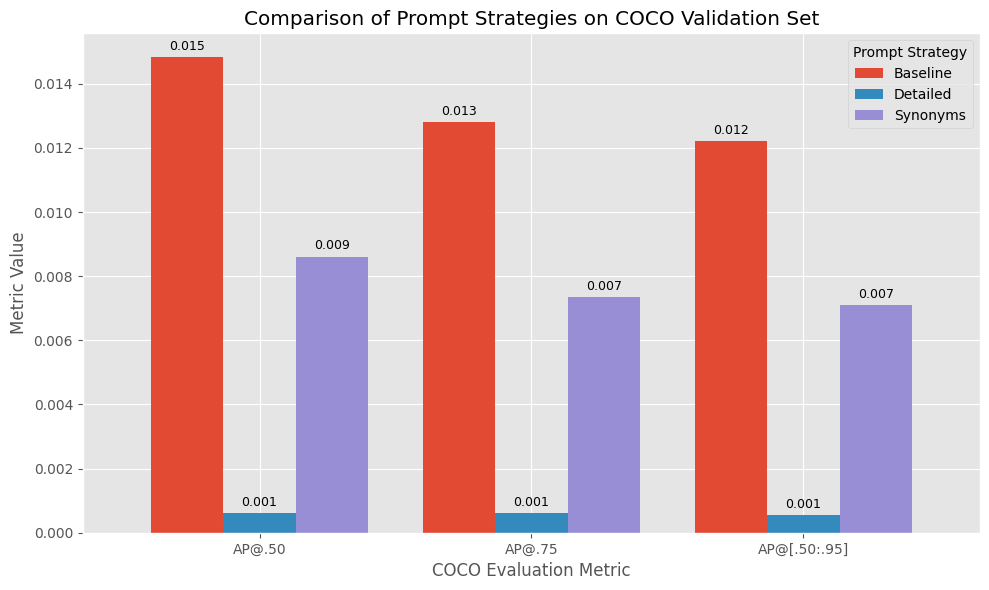

Analysis complete. Chart saved to: prompt_strategy_comparison_chart.png


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Define the paths to the generated CSV files
OUTPUT_DIR = "/kaggle/working/grounding_dino_final_outputs"
CSV_BASELINE = os.path.join(OUTPUT_DIR, "coco_eval_baseline_summary.csv")
CSV_DETAILED = os.path.join(OUTPUT_DIR, "coco_eval_detailed_summary.csv")
CSV_SYNONYMS = os.path.join(OUTPUT_DIR, "coco_eval_syn_summary.csv")

# Load each CSV into a DataFrame and add a 'Strategy' column
try:
    df_baseline = pd.read_csv(CSV_BASELINE)
    df_baseline['Strategy'] = 'Baseline'
except FileNotFoundError:
    print(f"File not found: {CSV_BASELINE}. Please ensure the main pipeline ran successfully.")
    df_baseline = pd.DataFrame()

try:
    df_detailed = pd.read_csv(CSV_DETAILED)
    df_detailed['Strategy'] = 'Detailed'
except FileNotFoundError:
    print(f"File not found: {CSV_DETAILED}. Please ensure the main pipeline ran successfully.")
    df_detailed = pd.DataFrame()
    
try:
    df_synonyms = pd.read_csv(CSV_SYNONYMS)
    df_synonyms['Strategy'] = 'Synonyms'
except FileNotFoundError:
    print(f"File not found: {CSV_SYNONYMS}. Please ensure the main pipeline ran successfully.")
    df_synonyms = pd.DataFrame()

# Combine all DataFrames and pivot for plotting
if not df_baseline.empty or not df_detailed.empty or not df_synonyms.empty:
    combined_df = pd.concat([df_baseline, df_detailed, df_synonyms])
    
    # Select key metrics for the plot
    metrics_to_plot = ["AP@[.50:.95]", "AP@.50", "AP@.75"]
    df_plot = combined_df[combined_df['metric'].isin(metrics_to_plot)]

    # Pivot the DataFrame for easy plotting
    df_pivot = df_plot.pivot(index='metric', columns='Strategy', values='value')
    
    # Create the plot
    plt.style.use('ggplot')
    fig, ax = plt.subplots(figsize=(10, 6))
    df_pivot.plot(kind='bar', ax=ax, width=0.8)

    # Set labels and title
    ax.set_ylabel("Metric Value")
    ax.set_xlabel("COCO Evaluation Metric")
    ax.set_title("Comparison of Prompt Strategies on COCO Validation Set")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

    # Add value labels on top of the bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', padding=3, fontsize=9)
    
    ax.legend(title='Prompt Strategy')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "prompt_strategy_comparison_chart.png"))
    plt.show()

    print("Analysis complete. Chart saved to: prompt_strategy_comparison_chart.png")
else:
    print("No data available to plot. Please check if the evaluation files were created.")

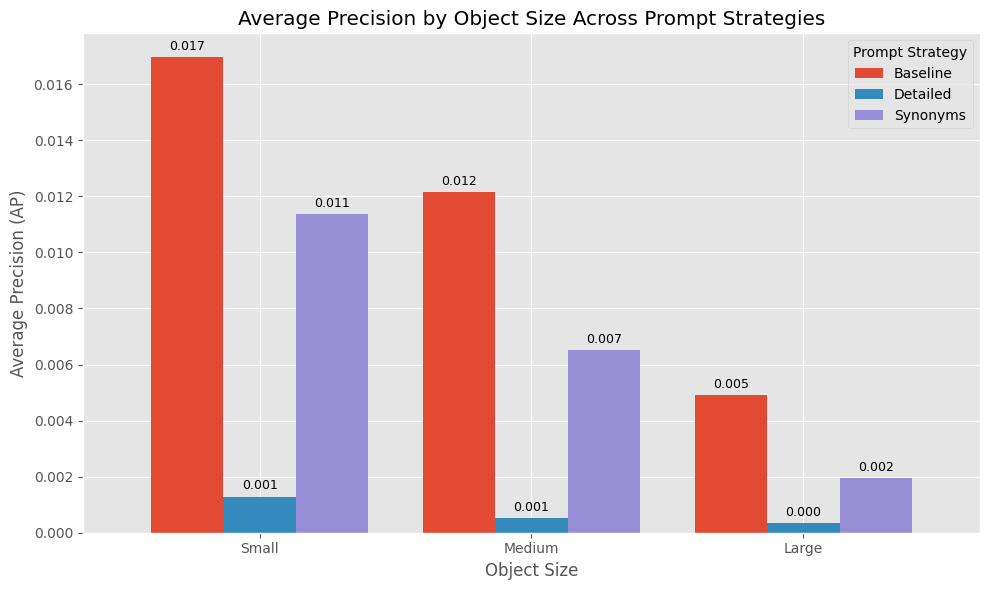

Analysis complete. Chart saved to: ap_by_size_comparison.png


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Define the paths to the generated CSV files
OUTPUT_DIR = "/kaggle/working/grounding_dino_final_outputs"
CSV_BASELINE = os.path.join(OUTPUT_DIR, "coco_eval_baseline_summary.csv")
CSV_DETAILED = os.path.join(OUTPUT_DIR, "coco_eval_detailed_summary.csv")
CSV_SYNONYMS = os.path.join(OUTPUT_DIR, "coco_eval_syn_summary.csv")

# Load each CSV into a DataFrame and add a 'Strategy' column
try:
    df_baseline = pd.read_csv(CSV_BASELINE)
    df_baseline['Strategy'] = 'Baseline'
except FileNotFoundError:
    df_baseline = pd.DataFrame()

try:
    df_detailed = pd.read_csv(CSV_DETAILED)
    df_detailed['Strategy'] = 'Detailed'
except FileNotFoundError:
    df_detailed = pd.DataFrame()
    
try:
    df_synonyms = pd.read_csv(CSV_SYNONYMS)
    df_synonyms['Strategy'] = 'Synonyms'
except FileNotFoundError:
    df_synonyms = pd.DataFrame()

# Combine all DataFrames and pivot for plotting
if not df_baseline.empty or not df_detailed.empty or not df_synonyms.empty:
    combined_df = pd.concat([df_baseline, df_detailed, df_synonyms])
    
    # Select AP metrics for different object sizes
    size_metrics = ["AP_small", "AP_medium", "AP_large"]
    df_plot_size = combined_df[combined_df['metric'].isin(size_metrics)]

    # Pivot the DataFrame for easy plotting
    df_pivot_size = df_plot_size.pivot(index='metric', columns='Strategy', values='value')
    
    # Create the plot
    plt.style.use('ggplot')
    fig, ax = plt.subplots(figsize=(10, 6))
    df_pivot_size.plot(kind='bar', ax=ax, width=0.8)

    # Set labels and title
    ax.set_ylabel("Average Precision (AP)")
    ax.set_xlabel("Object Size")
    ax.set_title("Average Precision by Object Size Across Prompt Strategies")
    ax.set_xticklabels(["Small", "Medium", "Large"], rotation=0)

    # Add value labels on top of the bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', padding=3, fontsize=9)
    
    ax.legend(title='Prompt Strategy')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "ap_by_size_comparison.png"))
    plt.show()

    print("Analysis complete. Chart saved to: ap_by_size_comparison.png")
else:
    print("No data available to plot. Please check if the evaluation files were created.")

### To download the output

In [12]:
import shutil

# Path to your output folder
folder_path = "/kaggle/working/grounding_dino_final_outputs"
shutil.make_archive("grounding_dino_outputs", 'zip', folder_path)


'/kaggle/working/grounding_dino_outputs.zip'